<a href="https://colab.research.google.com/github/1hamzaiqbal/probing-llm-math/blob/main/llm_math_probe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers accelerate

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
# Load tokenizer and model with FP16 precision on GPU
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="auto", dtype=torch.float16
)


`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.61G [00:00<?, ?B/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/6.62G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
import numpy as np

# Define the questions with their topics
questions = [
    ("Algebra", "Solve for x: 2x + 3 = 7."),
    ("Algebra", "Solve 3x^2 - 12 = 0 for x."),
    ("Algebra", "What is the sum of the roots of the equation x^2 - 5x + 6 = 0?"),
    ("Number Theory", "What is the greatest common divisor of 48 and 180?"),
    ("Number Theory", "Find the remainder when 7^5 is divided by 3."),
    ("Number Theory", "Determine if 2027 is a prime number."),
    ("Combinatorics", "How many ways can you choose 3 items from 5?"),
    ("Combinatorics", "How many subsets does a set of 4 elements have?"),
    ("Combinatorics", "In how many ways can the letters of the word \"CAT\" be arranged?")
]

mean_reps = []   # will hold mean-pooled hidden state for each layer, for each question
final_reps = []  # will hold final-token hidden state for each layer, for each question
topics = []
texts = []

for topic, question in questions:
    # Tokenize the question and get model outputs with all hidden states
    inputs = tokenizer(question, return_tensors="pt")
    inputs = inputs.to(model.device)  # move tokens to the same device as model
    outputs = model(**inputs, output_hidden_states=True, use_cache=False)
    hidden_states = outputs.hidden_states  # tuple of length (num_layers + 1)

    # Convert hidden states to CPU numpy for processing
    # Each hidden_state tensor shape: (batch=1, seq_len, hidden_dim)
    layer_hidden = [h.squeeze(0).detach().cpu().numpy() for h in hidden_states]

    # Compute mean-pooled and final-token representation for each layer
    layer_means = [h.mean(axis=0) for h in layer_hidden]   # list of shape (hidden_dim,)
    layer_finals = [h[-1] for h in layer_hidden]           # list of shape (hidden_dim,)

    mean_reps.append(layer_means)
    final_reps.append(layer_finals)
    topics.append(topic)
    texts.append(question)

# Convert to numpy arrays for saving
mean_reps = np.array(mean_reps, dtype=np.float32)    # shape: (n_questions, n_layers+1, hidden_dim)
final_reps = np.array(final_reps, dtype=np.float32)  # shape: (n_questions, n_layers+1, hidden_dim)
topics = np.array(topics)     # array of topic strings
texts = np.array(texts)       # array of question text strings

# Save to compressed NPZ file
np.savez_compressed("hidden_states_by_topic.npz", mean_pooled=mean_reps, final_token=final_reps, topics=topics, questions=texts)
print(f"Saved hidden states to 'hidden_states_by_topic.npz' (contains {mean_reps.shape[0]} questions).")


Saved hidden states to 'hidden_states_by_topic.npz' (contains 9 questions).


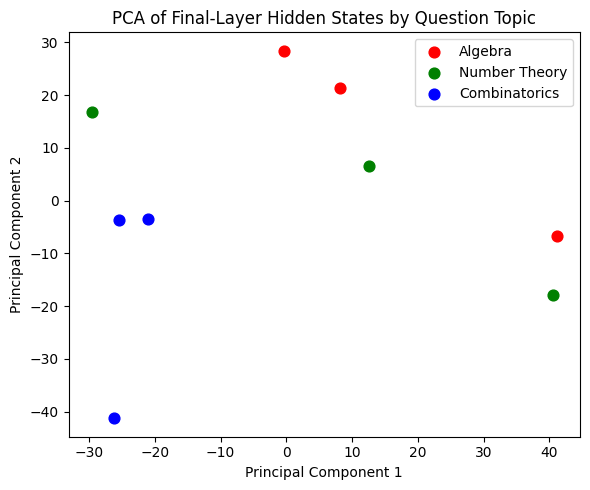

In [ ]:
# Load the saved hidden state data
data = np.load("hidden_states_by_topic.npz", allow_pickle=True)
mean_reps = data["mean_pooled"]      # shape: (9, layers+1, hidden_dim)
topics = data["topics"]             # shape: (9,) array of topic strings
questions_text = data["questions"]  # shape: (9,) array of question strings

# Use the mean-pooled representation from the final transformer layer (last index)
# If the model has N transformer layers, hidden_states includes N+1 entries (with the 0th as embeddings output).
final_layer_mean = mean_reps[:, -1, :]  # shape: (n_questions, hidden_dim)

# Perform PCA to reduce to 2D for visualization
X = final_layer_mean - final_layer_mean.mean(axis=0)   # center the data
# Compute SVD for PCA
U, S, Vt = np.linalg.svd(X, full_matrices=False)
# Project data onto the first two principal components
coords_2d = X.dot(Vt.T[:, :2])  # shape: (n_questions, 2)
x_coords = coords_2d[:, 0]
y_coords = coords_2d[:, 1]

# Assign a distinct color to each topic for plotting
topic_list = list(topics)
unique_topics = list(dict.fromkeys(topic_list))  # preserve order of appearance
colors_map = {"Algebra": "red", "Number Theory": "green", "Combinatorics": "blue"}

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
for topic in unique_topics:
    idxs = [i for i, t in enumerate(topic_list) if t == topic]
    plt.scatter(x_coords[idxs], y_coords[idxs], c=colors_map.get(topic, 'black'), label=topic, s=60)

plt.title("PCA of Final-Layer Hidden States by Question Topic")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!pip -q install scikit-learn


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

Z = np.load("hidden_states_by_topic.npz", allow_pickle=True)
MEAN = Z["mean_pooled"]      # (N, L+1, D)
LAST = Z["final_token"]      # (N, L+1, D)
topics = Z["topics"]         # (N,)
texts  = Z["questions"]      # (N,)
N, Lp1, D = MEAN.shape
labels = topics

def layer_feats(arr, layer_idx, rep="mean"):
    # arr: (N, L+1, D)
    X = arr[:, layer_idx, :]
    X = StandardScaler().fit_transform(X)  # z-score helps linear probes
    return X

def loo_logreg_acc(X, y):
    loo = LeaveOneOut()
    preds, trues = [], []
    # small N → stronger regularization (C small)
    clf = LogisticRegression(max_iter=5000, C=0.5)
    for train_idx, test_idx in loo.split(X):
        clf.fit(X[train_idx], y[train_idx])
        preds.append(clf.predict(X[test_idx])[0])
        trues.append(y[test_idx][0])
    return accuracy_score(trues, preds)

def plot_pca(X, y, title):
    pca = PCA(n_components=2, random_state=0)
    XY = pca.fit_transform(X)
    colors = {"Algebra":"red","Number Theory":"green","Combinatorics":"blue"}
    plt.figure(figsize=(6,5))
    for t in np.unique(y):
        idx = np.where(y==t)[0]
        plt.scatter(XY[idx,0], XY[idx,1], c=colors.get(t,"black"), label=t, s=70)
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.tight_layout(); plt.show()


Top layers by LOO-LogReg accuracy:
Layer  4 | mean | acc=0.778
Layer 10 | last | acc=0.778
Layer  0 | mean | acc=0.667
Layer  1 | mean | acc=0.667
Layer  1 | last | acc=0.667
Layer  5 | mean | acc=0.667
Layer 10 | mean | acc=0.667
Layer 11 | mean | acc=0.667


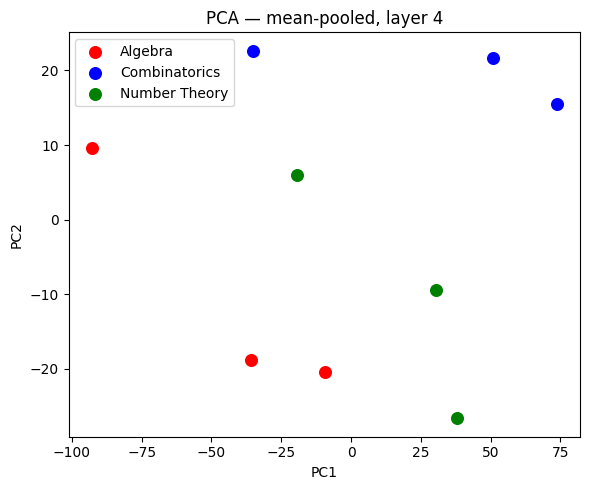

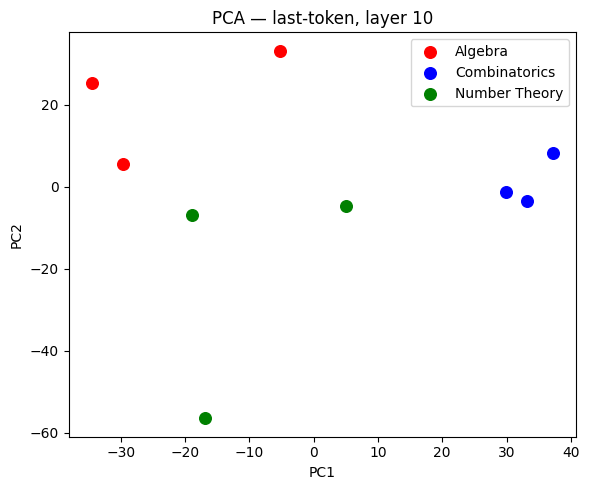

In [ ]:
# Evaluate every layer for both representations
acc_table = []
for layer in range(Lp1):  # includes embeddings at 0
    for rep_name, ARR in [("mean", MEAN), ("last", LAST)]:
        X = layer_feats(ARR, layer, rep=rep_name)
        acc = loo_logreg_acc(X, labels)
        acc_table.append((layer, rep_name, acc))

# Report top layers
acc_table_sorted = sorted(acc_table, key=lambda x: x[2], reverse=True)
print("Top layers by LOO-LogReg accuracy:")
for i in range(min(8, len(acc_table_sorted))):
    print(f"Layer {acc_table_sorted[i][0]:>2d} | {acc_table_sorted[i][1]:>4s} | acc={acc_table_sorted[i][2]:.3f}")

# Quick PCA plots for the best mean & best last-token layers
best_mean = max([(l,acc) for l,rep,acc in acc_table if rep=="mean"], key=lambda t:t[1])[0]
best_last = max([(l,acc) for l,rep,acc in acc_table if rep=="last"], key=lambda t:t[1])[0]

X_mean = layer_feats(MEAN, best_mean, "mean")
X_last = layer_feats(LAST, best_last, "last")

plot_pca(X_mean, labels, f"PCA — mean-pooled, layer {best_mean}")
plot_pca(X_last, labels, f"PCA — last-token, layer {best_last}")


Concat last-4 layers (mean) — LOO LogReg acc: 0.889


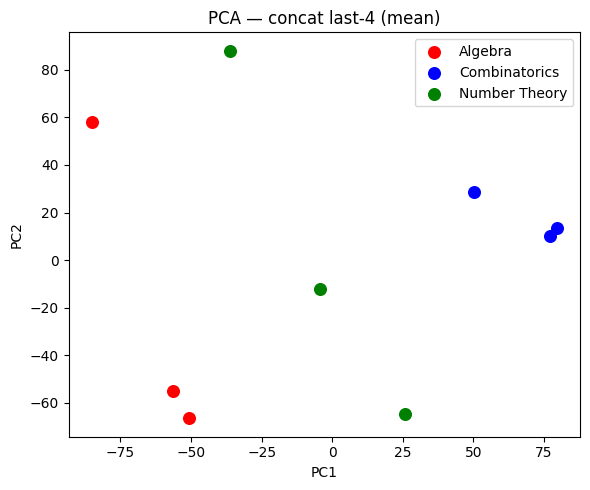

Concat last-4 layers (last) — LOO LogReg acc: 0.667


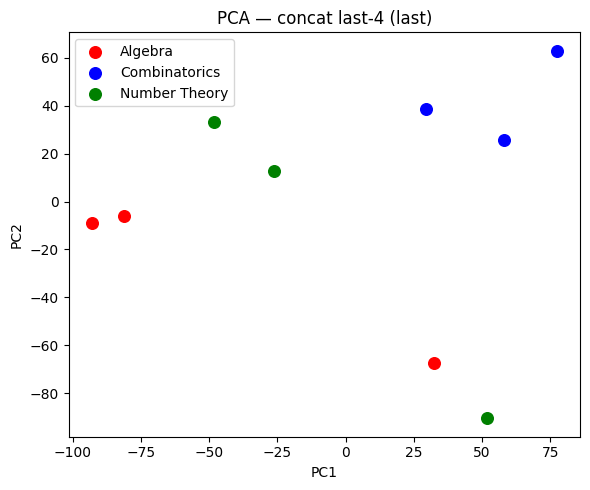

In [ ]:
def concat_last_k(ARR, k=4):
    # ARR: (N, L+1, D)
    sel = ARR[:, -k:, :]              # (N, k, D)
    X = sel.reshape(N, k*D)           # (N, k*D)
    X = StandardScaler().fit_transform(X)
    return X

for rep_name, ARR in [("mean", MEAN), ("last", LAST)]:
    Xk = concat_last_k(ARR, k=4)
    acc_k = loo_logreg_acc(Xk, labels)
    print(f"Concat last-4 layers ({rep_name}) — LOO LogReg acc: {acc_k:.3f}")
    plot_pca(Xk, labels, f"PCA — concat last-4 ({rep_name})")


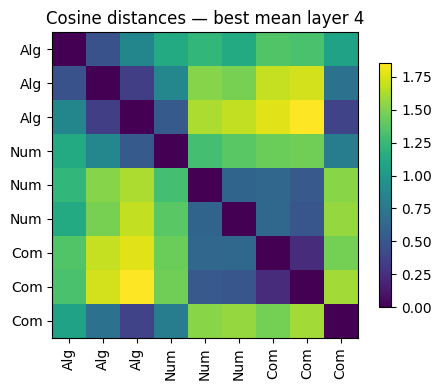

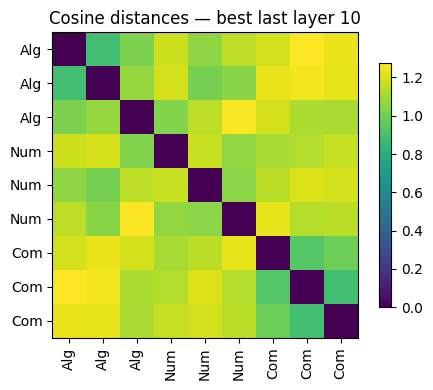

In [ ]:
def cosine_heatmap(X, y, title):
    Dm = pairwise_distances(X, metric="cosine")
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    im = ax.imshow(Dm, cmap="viridis")
    ax.set_title(title); fig.colorbar(im, ax=ax, shrink=0.8)
    ax.set_xticks(range(len(y))); ax.set_yticks(range(len(y)))
    ax.set_xticklabels([t[:3] for t in y], rotation=90)
    ax.set_yticklabels([t[:3] for t in y])
    plt.tight_layout(); plt.show()

cosine_heatmap(X_mean, labels, f"Cosine distances — best mean layer {best_mean}")
cosine_heatmap(X_last, labels, f"Cosine distances — best last layer {best_last}")


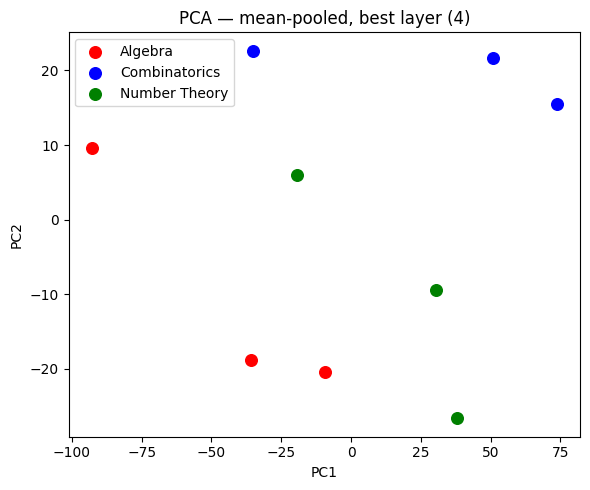

In [13]:
# Use the mean-pooled representation from the final transformer layer (last index)
# If the model has N transformer layers, hidden_states includes N+1 entries (with the 0th as embeddings output).
# For visualizing all mean-pooled states across layers, we'll need to adapt.
# For now, let's plot the mean-pooled representation from the best performing layer as identified earlier.
# The best mean-pooled layer is stored in the `best_mean` variable.

X_mean_best_layer = layer_feats(MEAN, best_mean, "mean")

plot_pca(X_mean_best_layer, labels, f"PCA — mean-pooled, best layer ({best_mean})")

In [12]:
import numpy as np

# Load the saved hidden state data
data = np.load("hidden_states_by_topic.npz", allow_pickle=True)

print("Contents of hidden_states_by_topic.npz:")
for key in data.keys():
    print(f"- '{key}': shape = {data[key].shape}")

Contents of hidden_states_by_topic.npz:
- 'mean_pooled': shape = (9, 29, 3584)
- 'final_token': shape = (9, 29, 3584)
- 'topics': shape = (9,)
- 'questions': shape = (9,)


In [16]:
import shutil
import os

def copy_to_drive(filename):
    """Copies a file to the root of the user's Google Drive 'MyDrive'."""
    drive_path = '/content/drive/MyDrive/'
    source_path = f'/content/{filename}'
    destination_path = os.path.join(drive_path, filename)

    if not os.path.exists('/content/drive'):
        print("Google Drive not mounted. Please mount your Google Drive first.")
        return

    if not os.path.exists(source_path):
        print(f"Error: File not found at {source_path}")
        return

    try:
        shutil.copy(source_path, destination_path)
        print(f"Successfully copied {filename} to {destination_path}")
    except Exception as e:
        print(f"Error copying file: {e}")

# Example usage:
copy_to_drive('hidden_states_by_topic.npz')

Successfully copied hidden_states_by_topic.npz to /content/drive/MyDrive/hidden_states_by_topic.npz


**Note:** Before running the `copy_to_drive` function, make sure you have mounted your Google Drive in Colab. You can do this by clicking the folder icon on the left sidebar, then the mountain icon with a play button.